In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv('loan_data.csv')

# Check for missing values and data types
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB
None
credit.policy        0
purpose              0
int.rate    

In [2]:
# Drop missing values
df = df.dropna()

In [3]:
# One-hot encoding for the 'purpose' categorical column
df = pd.get_dummies(df, columns=['purpose'], drop_first=True)

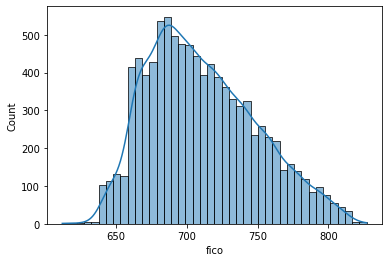

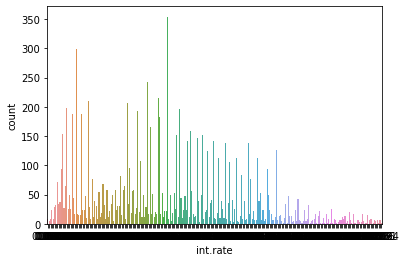

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of continuous variables
sns.histplot(df['fico'], kde=True)
plt.show()

# Visualizing the target variable (default probability)
sns.countplot(x='int.rate', data=df)
plt.show()

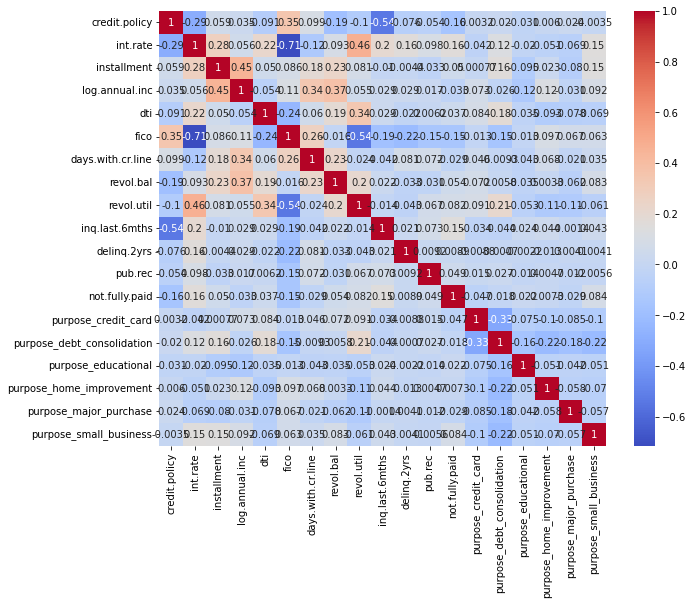

In [5]:
# Correlation matrix
correlation = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

In [6]:
# Drop features that are highly correlated
#df = df.drop(['int.rate'], axis=1)

# Remove highly correlated features
import numpy as np
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
df = df.drop(columns=to_drop)

print(f'Dropped columns: {to_drop}')

Dropped columns: []


In [7]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
# continuous_features = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'revol.bal', 'revol.util']
continuous_features = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'revol.bal', 'revol.util']


df[continuous_features] = scaler.fit_transform(df[continuous_features])

In [8]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop('not.fully.paid', axis=1)
y = df['not.fully.paid']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Initialize the model
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.3))

# Second hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

2025-01-10 12:47:10.023713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


VOC-NOTICE: GPU memory for this assignment is capped at 1024MiB


2025-01-10 12:47:11.987665: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/20
240/240 [==============================] - 1s 2ms/step - loss: 35.5216 - accuracy: 0.7317 - val_loss: 0.9495 - val_accuracy: 0.8356
Epoch 2/20
240/240 [==============================] - 0s 1ms/step - loss: 2.0282 - accuracy: 0.7886 - val_loss: 0.5666 - val_accuracy: 0.8408
Epoch 3/20
240/240 [==============================] - 0s 1ms/step - loss: 0.7739 - accuracy: 0.8245 - val_loss: 0.4659 - val_accuracy: 0.8408
Epoch 4/20
240/240 [==============================] - 0s 1ms/step - loss: 0.5980 - accuracy: 0.8340 - val_loss: 0.4463 - val_accuracy: 0.8408
Epoch 5/20
240/240 [==============================] - 0s 1ms/step - loss: 0.5518 - accuracy: 0.8365 - val_loss: 0.4446 - val_accuracy: 0.8408
Epoch 6/20
240/240 [==============================] - 0s 1ms/step - loss: 0.5009 - accuracy: 0.8378 - val_loss: 0.4562 - val_accuracy: 0.8408
Epoch 7/20
240/240 [==============================] - 0s 1ms/step - loss: 0.5034 - accuracy: 0.8380 - val_loss: 0.4925 - val_accuracy: 0.8408
Epoch

In [10]:
# Evaluate model
results = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {results[1]*100:.2f}%")

60/60 [==============================] - 0s 666us/step - loss: 0.4384 - accuracy: 0.8408
Test Accuracy: 84.08%


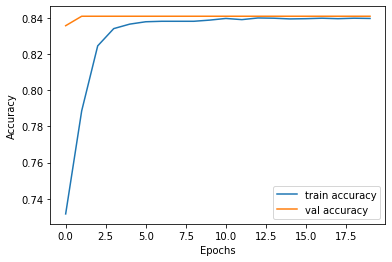

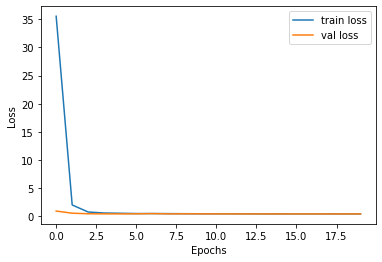

In [11]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()